## Imports Everythings

In [0]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pathlib

In [2]:
tf.__version__

'2.1.0'

## Load Data

In [0]:
!wget https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/Movie_Poster_Dataset.zip

In [0]:
!unzip Movie_Poster_Dataset.zip

In [0]:
!wget https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/Movie_Poster_Metadata.zip

In [0]:
!unzip Movie_Poster_Metadata.zip

## Show some random Image

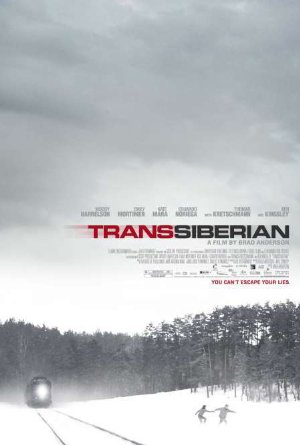

In [1]:
import os
from PIL import Image

path = "Movie_Poster_Dataset"
folder = os.listdir(path)[10]
path = os.path.join(path, folder)
name =  os.listdir(path)[90]
path = os.path.join(path, name)
Image.open(path)

## Create Label from Meta Data

File is not formatted in a particular format

<pre>
    {
        .........
    }

    {
        .......
    }
</pre>

So, this file can be converted easily if a comma is added next to "}"

In [1]:
import json
import os

def process(p):
  f = open(p, "rb")
  s = f.read()
  # This two file did not decode with utf-16  
  if "1981" in p or "1980" in p:
    sd = s.decode("utf-8")
  else:
    sd = s.decode("utf-16")

  sd = sd.strip()
  # The file don't have any format,
  # trying to make a json file
  sd2 = sd.replace("}", "},")
  # drop last ','
  sd2 = sd2[:-1]
  # to make this file as json we need to remove obejct ID ()
  sd2 = sd2.replace("ObjectId(", "")
  # maybe some ) sign will be remove from other filed,
  # but those filed will not need
  sd2 = sd2.replace(")", "")
  # convert to json list
  sd2 = "["+sd2+"]"
  js = json.loads(sd2)
  return js

In [0]:
img_path = []
img_id = []
genres = []
movie_path = "Movie_Poster_Dataset"
label_path = "groundtruth"

for text_file in os.listdir(label_path):
  path = os.path.join(label_path, text_file)
  js = process(path)
  for obj in js:
    imgid = obj['imdbID']
    gen = obj['Genre']
    # now file
    text_file = text_file.replace(".txt", "")
    img = os.path.join(movie_path+'/'+text_file, imgid+".jpg")
    # some id existis in meta data, but not found in image folder
    # almost 800 images are missing
    if os.path.exists(img):
      # append
      img_path.append(img)
      img_id.append(imgid)
      genres.append(gen)
      

In [0]:
import pandas as pd

dit = {
    "Image Id":img_id,
    "Genere" : genres,
    "Image Path": img_path}


# create dataframe
df = pd.DataFrame(dit)

In [5]:
df.tail()

,Image Id,Genere,Image Path
8059,tt0207341,"Comedy, Drama, Romance",Movie_Poster_Dataset/1999/tt0207341.jpg
8060,tt0185711,Comedy,Movie_Poster_Dataset/1999/tt0185711.jpg
8061,tt0160620,"Crime, Drama, Thriller",Movie_Poster_Dataset/1999/tt0160620.jpg
8062,tt0201290,Comedy,Movie_Poster_Dataset/1999/tt0201290.jpg
8063,tt0203027,"Action, Thriller",Movie_Poster_Dataset/1999/tt0203027.jpg


Load an image from dataframe

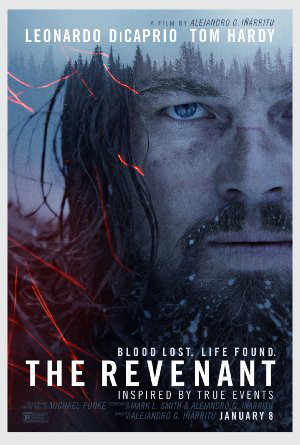

In [6]:
Image.open(df['Image Path'][10])

## Now one hot encoding
This datasets has 24 unique labels

In [0]:
def one_hot_encoding(gen):
  li = []

  for i in gen:
    gens =  [j.strip() for j in i.split(",")]
    li = li +gens
  
  # converts to set to findout the unique values
  uni = set(li)
  # create a dictionary
  di=dict.fromkeys(uni, [0]*len(gen))
  # encode
  for p, v in enumerate(gen):
    inp = [j.strip() for j in v.split(",")]
    for j in inp:
        data = di[j].copy()
        data[p]=1
        di[j] = data
    
  #return dataframe
  return pd.DataFrame(di)

In [0]:
lab = one_hot_encoding(df['Genere'])

In [9]:
lab.head()

,Reality-TV,War,Short,Crime,Thriller,Mystery,News,Documentary,Musical,Music,Romance,History,Sport,Drama,Action,Biography,Horror,Adventure,Animation,Family,Fantasy,N/A,Western,Comedy,Sci-Fi
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
3,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0


drop N/A cloumn

In [0]:
del lab['N/A']

check both dataframe is same size or not

In [11]:
len(df), len(lab)

(8064, 8064)

In [0]:
data = pd.concat([df, lab], axis=1, join='inner')

In [13]:
data.head()

,Image Id,Genere,Image Path,Reality-TV,War,Short,Crime,Thriller,Mystery,News,Documentary,Musical,Music,Romance,History,Sport,Drama,Action,Biography,Horror,Adventure,Animation,Family,Fantasy,Western,Comedy,Sci-Fi
0,tt0369610,"Action, Adventure, Sci-Fi",Movie_Poster_Dataset/2015/tt0369610.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
1,tt2395427,"Action, Adventure, Sci-Fi",Movie_Poster_Dataset/2015/tt2395427.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
2,tt2096673,"Animation, Adventure, Comedy",Movie_Poster_Dataset/2015/tt2096673.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
3,tt2820852,"Action, Crime, Thriller",Movie_Poster_Dataset/2015/tt2820852.jpg,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,tt2293640,"Animation, Comedy, Family",Movie_Poster_Dataset/2015/tt2293640.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0


In [14]:
data.shape

(8064, 27)

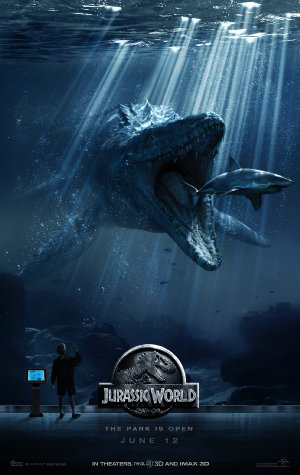

In [15]:
Image.open(data['Image Path'][0])

## Resize and process images

In [18]:
img_width = 350
img_height = 350

X = []

for i in tqdm(range(data.shape[0])):
  path = data['Image Path'][i]
  img = image.load_img(path, target_size=(img_width, img_height, 3))
  img = image.img_to_array(img)
  img = img/255.0
  X.append(img)

X = np.array(X)

100%|██████████| 8064/8064 [00:33<00:00, 238.28it/s]


In [19]:
X.shape

(8064, 350, 350, 3)

### Show a image

Text(0.5, 1.0, 'Biography, Drama, History')

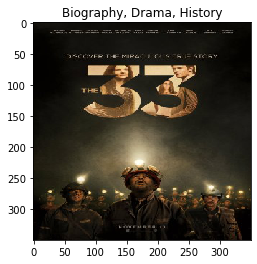

In [20]:
plt.imshow(X[100])
plt.title(data['Genere'][100])

### Prepare labels

In [21]:
y = data.iloc[:, 3:]
y = y.to_numpy()
y.shape

(8064, 24)

split datasets into train and test, split percentage = 0.15

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.15)

In [23]:
X_train[0].shape

(350, 350, 3)

## Define model

In [0]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape = X_train[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(24, activation='sigmoid'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 348, 348, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 348, 348, 16)      64        
_________________________________________________________________
dropout (Dropout)            (None, 348, 348, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 346, 346, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 346, 346, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 173, 173, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 173, 173, 32)      0

In [0]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [27]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Train on 6854 samples, validate on 1210 samples
Epoch 1/5
6854/6854 [==============================] - 39s 6ms/sample - loss: 0.6711 - accuracy: 0.6647 - val_loss: 0.3302 - val_accuracy: 0.9021
Epoch 2/5
6854/6854 [==============================] - 34s 5ms/sample - loss: 0.3010 - accuracy: 0.8932 - val_loss: 0.2634 - val_accuracy: 0.9020
Epoch 3/5
6854/6854 [==============================] - 34s 5ms/sample - loss: 0.2676 - accuracy: 0.9039 - val_loss: 0.2620 - val_accuracy: 0.9027
Epoch 4/5
6854/6854 [==============================] - 34s 5ms/sample - loss: 0.2602 - accuracy: 0.9062 - val_loss: 0.2636 - val_accuracy: 0.9030
Epoch 5/5
6854/6854 [==============================] - 34s 5ms/sample - loss: 0.2555 - accuracy: 0.9072 - val_loss: 0.2640 - val_accuracy: 0.9030


## Show history

In [0]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

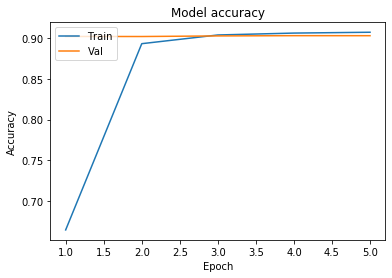

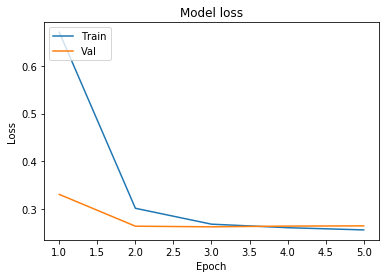

In [29]:
plot_learningCurve(history, 5)

## Now test

In [0]:
classes = ['Family', 'Sport', 'Short', 'Drama', 'News', 'Thriller', 'History',
       'Sci-Fi', 'Adventure', 'Fantasy', 'Comedy', 'Music', 'Reality-TV',
       'War', 'Action', 'Biography', 'Western', 'Animation', 'Crime',
       'Mystery', 'Horror', 'Musical', 'Romance', 'Documentary'] 

In [30]:
!wget https://images-na.ssl-images-amazon.com/images/I/51%2Bzb74v-TL.jpg

--2020-01-19 10:00:53--  https://images-na.ssl-images-amazon.com/images/I/51%2Bzb74v-TL.jpg
Resolving images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)... 13.35.3.187
Connecting to images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)|13.35.3.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51741 (51K) [image/jpeg]
Saving to: ‘51+zb74v-TL.jpg.1’

51+zb74v-TL.jpg.1   100%[===================>]  50.53K  --.-KB/s    in 0s      

2020-01-19 10:00:53 (271 MB/s) - ‘51+zb74v-TL.jpg.1’ saved [51741/51741]



In [0]:
def get_laebls(y):
  li = len(np.where(y > 0.20)[1])
  pred = np.argsort(y)[0][:-li:-1]
  labels = []
  for i in pred:
    labels.append(classes[i])

  ## if labels more than 4
  ## drop last
  if len(labels) > 4:
    return labels[:4]
  else:  
    return labels

War, Action, News


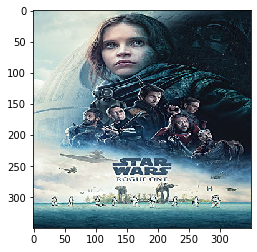

In [108]:
img_width = 350
img_height = 350

img = image.load_img('51+zb74v-TL.jpg', target_size=(img_width, img_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0

img = img.reshape(1, img_width, img_height, 3)

#classes = data.columns[3:]
y_prob = net.predict(img)
out = get_laebls(y_prob)
print(*out, sep=', ')

## Save model

In [0]:
model.save("model.h5")

The model size is around 350 mb+

Lets convert to TF lite

## Convert Modle to TF lite

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(net)
tflite_model = converter.convert()

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(net)
tflite_model = converter.convert()

In [0]:
tflite_models_dir = pathlib.Path("opti/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [19]:
tflite_model_file = tflite_models_dir/"movie.tflite"
tflite_model_file.write_bytes(tflite_model)

110645824

#### Convert to float 32 into float 16

In [0]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

In [21]:
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"movie_optimized.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

55329588

## Load Tensorflow lite model

In [0]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [0]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

## Test TF lite model

In [0]:
#test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
interpreter.set_tensor(input_index, img)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

In [93]:
get_laebls(predictions)

[13 14  4]


['War', 'Action', 'News']

### Test optimized model

In [0]:
#test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)
input_index = interpreter_fp16.get_input_details()[0]["index"]
output_index = interpreter_fp16.get_output_details()[0]["index"]
interpreter_fp16.set_tensor(input_index, img)
interpreter_fp16.invoke()
predictions2 = interpreter_fp16.get_tensor(output_index)

In [95]:
get_laebls(predictions2)

[13 14  4]


['War', 'Action', 'News']

# Compare outputs

In [109]:
print("Output from tensorflow model:", *out, sep=', ')
print("Output from tensorflow lite model:", *get_laebls(predictions), sep=', ')
print("Output from tensorflow lite optimized model:", *get_laebls(predictions2), sep=', ')

Output from tensorflow model:, War, Action, News
Output from tensorflow lite model:, War, Action, News
Output from tensorflow lite optimized model:, War, Action, News
